# Exploring structured entries in MIMIC

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'asamadan'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser)

# # the below statement is prepended to queries to ensure they select from the right schema
# query_schema = 'set search_path to ' + schema_name + ';'

In [2]:
# read tables and set 'subject_id' as index
Tables = ['admissions', 
          'patients', 
          'ICUstays',
          'diagnoses_icd',
          'procedures_icd',
          'callout']
for x in Tables:
    exec("%s = pd.read_sql('select * from mimiciii.%s', con).set_index('subject_id', drop=False)"%(x,x))
    

## Merge the tables
- Admissions
- Patients
- ICUstays
- Diagnosis
    - There are multiple diagnosis for each patient. For now, the top diagnosis is used
- Callout
- Procedures_icd
    - There are multiple procedures for each patient. For now, the top diagnosis is used


In [3]:
diagnoses_icd  = diagnoses_icd.groupby(diagnoses_icd.index).apply(lambda x:x[x['seq_num'] == 1])
procedures_icd = procedures_icd.groupby(procedures_icd.index).apply(lambda x:x[x['seq_num'] == 1])
# # confirming that only the top diagnosis is returned 
# diagnoses_icd.seq_num.value_counts()
# procedures_icd.seq_num.value_counts()


In [4]:
# Merge the tables
import functools

# first merge admissions with patient based on 'subject_id'
admissions       = pd.merge(admissions, patients[patients.columns.difference(admissions.columns)],
                            how='left', left_index=True, right_index=True)

# set 'hadm_id' as index for the remaning tables and admissions
for x in ['admissions', 'ICUstays', 'diagnoses_icd', 'callout']:
    eval("%s.set_index('hadm_id', drop=False, inplace=True)"%x)
    
# then, merge the resulting admissions with the rest of the tables using 'hadm_id'
dfs              = [admissions, ICUstays, diagnoses_icd, callout]
# Data             = [pd.merge(left,right, how='left', on='subject_id') for left, right in zip(dfs, dfs[1:])]
Data             = functools.reduce(lambda left,right: 
                                    pd.merge(left,right[right.columns.difference(left.columns)], 
                                             how='left', left_index=True, right_index=True), dfs)


## FF vs NFF 
- This function takes admission for a subject and determines whether the subject is a FF or NFF


In [5]:
def SubjectCheck(subject):
    data = None
    NFF = 0
    if len(subject) > 2:
        Admission_Time = subject.admittime
        # gaps between every second admissions
        Inter_Admission_Gaps = np.array([(Admission_Time.iloc[x+2]-Admission_Time.iloc[x])/np.timedelta64(1, 'D')
         for x in range(len(subject)-2)] )       

        # for FF, we take their first admission
        if sum(Inter_Admission_Gaps<365):
            # take the first ICU admisson
            # appending the label to the end of the array
            return np.append(subject.iloc[np.where(Inter_Admission_Gaps<365)[0][0]].values, 1)
        else: # not a FF
            NFF = 1
    
    if len(subject) < 2 or NFF:
        # check if the patient is still alive
        if not(subject.expire_flag.iloc[0]):
            # appending the label to the end of the array
            return np.append(subject.iloc[0].values, 0)
#         else: 
#             data = None
#     return data
        
DATA = {}        
for subject, subject_data in Data.groupby('subject_id'):
     
    DATA[subject] = SubjectCheck(subject_data)

In [6]:
# convert dictionary to dataframe and label as the last column
DATA = dict((key,x) for key,x in DATA.items() if x is not None)
a = pd.DataFrame.from_dict(DATA, orient='index')
a.columns = np.append(Data.columns, 'Label')



4 days
2 days 17:31:58


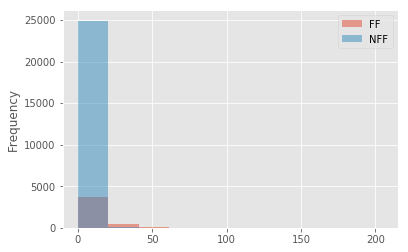

In [7]:
import sys 
a.admittime-a.dob
a.dob.iloc[0],a.admittime.iloc[0]
a.last_careunit.value_counts()
print('%s'%np.percentile(a.dischtime - a.outtime,75).astype('timedelta64[D]'))
print('%s'%(a.dischtime - a.outtime).median())

aaF = (abs(a.dischtime.loc[a.Label==1]-a.outtime.loc[a.Label==1])/np.timedelta64(1,'D')) 
aaNF= (abs(a.dischtime.loc[a.Label==0]-a.outtime.loc[a.Label==0])/np.timedelta64(1,'D')) 

# replace close to zero values with epsilon
aaF.loc[aaF<sys.float_info.epsilon] = sys.float_info.epsilon
aaNF.loc[aaNF<sys.float_info.epsilon] = sys.float_info.epsilon


pd.DataFrame({'FF': aaF, 'NFF': aaNF}).plot(kind='hist',alpha =0.5)

# Structured variables:
- Admission type
- Admission location
- Discharge location
- Insurance type
- Marital status
- Diagnosis
    - There are multiple diagnoses for each patient. There are two ways to handle this
        1. Only consider the top diagnosis based on `seq_num` from `diagnoses_icd` table
        2. Create one-hot-encoding of all icd codes, so that an icd code `A` is boolean features that will be `ON` if a patient is diagnosed to have `A`.
    - A smaller set of diagnosis may be created by consolidated similar conditions e.g., 
    1. CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA 
    2. CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA (notice spacing differnce)
    
- Age (Admission time - DOB: a.admittime-a.dob)
    - Probably, we need to bin the age into 3 to 4 groups (e.g., newborns?, $<$75, 75-89, $>$90)
- Gender 
- Care unit   
    - First care unit
    - Last care unit
- Length of stay (Icustays)

- `CALLOUT`
 - Binary requests indicating special precausions requested for the patient in the subsequent ward
     -`REQUEST_TELE`, `REQUEST_RESP`, `REQUEST_CDIFF`, `REQUEST_MRSA`, `REQUEST_VRE`
 - DISCHARGE_WARDID

## Frequent flyer indicator
    - Label column

## Potential derived features
- Admission time
    - season
    - time of the day
    - day of the week (weekday vs weekend)
- Discrepancies between first and last care units,
    - First care unit == Last care unit (5% of patients have different first and last care units)
    
- Time between ICU discharge and hospital discharge
    - Discharge time - Out time ==> (median = 2 days, IQR (1-4 days))
        - I think this information is also available in the `CALLOUT` table
    



# Classification
- Start with Logistic regression, evaluated using 100 (70/30% train/test) subsamples


In [8]:
# drop irrelevant col
a.drop(['language', 'religion','ethnicity', 'diagnosis','icd9_code',
       'dbsource', 
       'row_id',
       'subject_id',
       'hadm_id',
       'dischtime',
       'deathtime',
       'edregtime',
       'edouttime',
       'hospital_expire_flag',
       'has_chartevents_data',
       'dod',
       'dod_hosp',
       'dod_ssn',
       'expire_flag',
       'first_wardid',
       'icustay_id',
       'intime',
       'last_wardid',
       'outtime',
       'seq_num',
       'acknowledge_status',
       'acknowledgetime',
       'callout_outcome',
       'callout_service',
       'callout_status',
       'callout_wardid',
       'createtime',
       'curr_careunit',
       'curr_wardid',
       'currentreservationtime',
       'discharge_wardid',
       'firstreservationtime',
       'outcometime',
       'submit_careunit',
       'submit_wardid',
       'updatetime'], axis=1, inplace=True)

In [9]:
# Compute Age and define bins
Age = (a.admittime-a.dob)/np.timedelta64(1,'Y')
Age.loc[np.logical_and(Age>0, Age<=1)]   = 1
Age.loc[np.logical_and(Age>1, Age<=25)]  = 2
Age.loc[np.logical_and(Age>25, Age<=50)] = 3
Age.loc[np.logical_and(Age>50, Age<=75)] = 4
Age.loc[np.logical_and(Age>75, Age<=90)] = 5
Age.loc[Age<0]                           = 6
a.drop(['admittime','dob'], axis=1, inplace=True)
a.Age = Age

In [10]:
# prepare the data for classificaton
Categorical_cols = a.select_dtypes(['object']).columns
for x in Categorical_cols:
    a[x] = a[x].astype('category')
    a[x] = a[x].cat.codes

In [11]:
# I am going to remove the request cols for now as they are full of NaNs
a.drop([x for x in a.columns if 'request' in x], axis=1, inplace=True)

In [12]:
X = a.iloc[:,:-1] # variables
y = a.iloc[:,-1] #labels

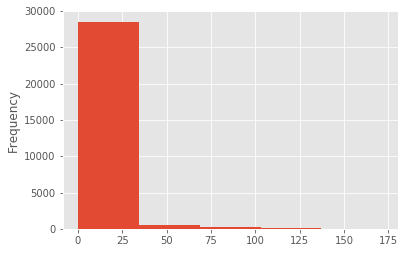

In [13]:
# finding cols with NaN
X.isnull().any()
X.los.plot.hist(bins = 5)
Los = X.los
X.drop('los', axis=1, inplace=True)

In [14]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

LR_clf  = LogisticRegression(penalty='l2')#, class_weight='balanced')
# SGD_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha = 0.01, l1_ratio=0.5, n_jobs=-1)

RandomSplits = StratifiedShuffleSplit(n_splits=100, test_size=0.3)

# Scores=cross_val_score(LR_clf, X, y, cv=RandomSplits, scoring='roc_auc')

Coef = {}
from sklearn.metrics import roc_auc_score
Scores=[]
d = 0
for train_indices, test_indices in RandomSplits.split(X,y):
    model = LR_clf.fit(X.iloc[train_indices], y.iloc[train_indices])
    Scores.append(roc_auc_score(y.iloc[test_indices], model.predict_proba(X.iloc[test_indices])[:,1]))
    Coef[d] = model.coef_[0]
    d+=1

AUC (median-IQR): 0.71-(0.70-0.72)


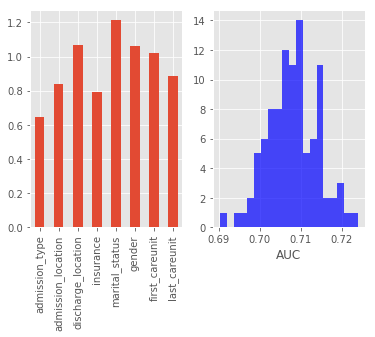

In [36]:
%matplotlib inline
Coef= pd.DataFrame(Coef).T
Coef.columns = X.columns
OddRatios = np.exp(Coef.median()).to_frame()

ax =plt.subplot(1,2,1)
OddRatios.plot.bar(ax=ax,legend=False)

plt.subplot(1,2,2)
plt.hist(Scores, 20,facecolor='b', alpha=.7),plt.xlabel('AUC')
print('AUC (median-IQR): %.2f-(%.2f-%.2f)'%(np.median(Scores), np.percentile(Scores,5), np.percentile(Scores,95)))

In [37]:
#ConfIntervals of odd ratios 
Conf = pd.DataFrame(columns=['2.5%', '50%', '97.5%'])
np.exp(Coef.quantile([0.025, 0.5, 0.975]).T)

,0.025,0.5,0.975
admission_type,0.622301,0.649067,0.674458
admission_location,0.827958,0.840351,0.853576
discharge_location,1.060166,1.065707,1.070654
insurance,0.779337,0.794869,0.809882
marital_status,1.199473,1.211872,1.225325
gender,1.024732,1.062457,1.121821
first_careunit,0.983068,1.022682,1.071266
last_careunit,0.843933,0.884008,0.927494
